3
For df_0Nmslope 3-1.csv: row=0, col=0
For df_100Nmslope 3-1.csv: row=0, col=1
For df_200Nmslope 3-1.csv: row=1, col=0


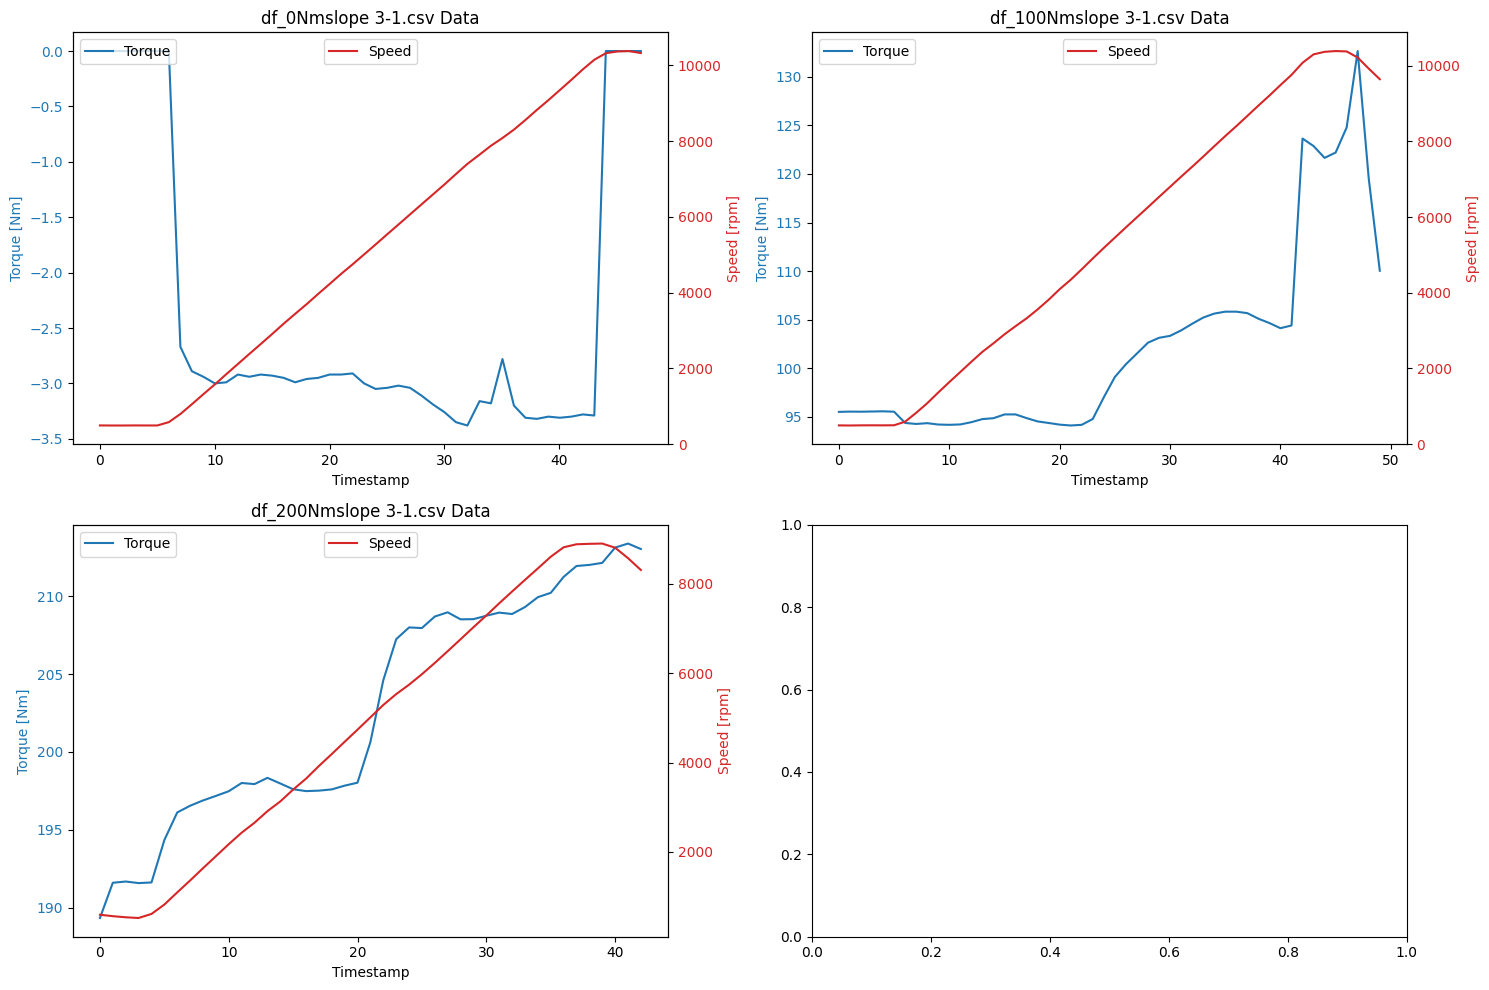

In [61]:
import pandas as pd
import os
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#針對KF NVH的數據來快速看曲線
#說明: 該程式為抓出Delta6 使用SAM程式紀錄的數據並篩選出Torque和Speed的圖表
#line#13 -> 其中數據中"TIME" 透過Pare_time進行轉換
#line#66 -> 0為起始欄,將欄位1~16刪除
#line#88 -> 判斷檔案數量決定圖表的排列


def parse_time(time_str): #拆解資料中時間格式 --> 2024y1m11d_pm 11:00:21.486
    date_part, time_part = time_str.split('_')
    year_part, month_day_part = date_part.split('y')
    year = int(year_part)
    month_day = month_day_part.split('m')
    month = int(month_day[0])
    day = int(month_day[1].split('d')[0])
    time_parts = time_part.split(' ')
    period = time_parts[0]
    hour_minute_second = time_parts[1].split(':')
    hour = int(hour_minute_second[0])
    minute = int(hour_minute_second[1])
    second_parts = hour_minute_second[2].split('.')
    second = int(second_parts[0])
    microsecond = int(second_parts[1]) * 1000  # 將毫秒轉換為微秒

    if period == 'pm' and hour < 12:
        hour += 12
    elif period == 'am' and hour == 12:
        hour = 0

    # return datetime(year, month, day, hour, minute, second, microsecond)
    dt = datetime(year, month, day, hour, minute, second, microsecond)
    return dt.timestamp()  # 返回時間戳的數值

# 指定資料夾路徑
folder_path = r'D:\\py_env_data\\Delta6_NVH\\'

# 遍歷資料夾內的 CSV 檔案
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
# print(csv_files)

# 儲存數據的字典
dfs = {}

# 讀取每個 CSV 檔案並根據檔名中的特定字眼進行分類
for file in csv_files:
    file_name = os.path.basename(file)
    try:
        # 從檔名中提取特定字眼，這裡是提取100Nm的部分
        keyword = file_name.split('_')[1]+file_name.split('_')[2]

        # 讀取CSV檔案
        df = pd.read_csv(file)

        # 轉換時間欄位
        df['Time'] = df['Time'].apply(parse_time)
        # 計算時間差 放入欄位"X"中
        df['X'] = df['Time'].diff()
        df.iloc[0,0] = 0
        # 累積時間差，放入 "X" 欄位中
        df['X'] = df['X'].cumsum()

        # 刪除指定的欄位
        start_idx = 1
        end_idx = 16
        df = df.drop(df.columns[start_idx:end_idx], axis=1)

        # 將DataFrame存入字典中，以特定字眼命名
        dfs[f'df_{keyword}'] = df
        # print(dfs)
    except IndexError:
        print(f"檔名不符合預期格式: {file_name}")

# 設定子圖表的列和行數
print(len(dfs))
if len(dfs) <=3:
    num_cols = 2  # 每行顯示 2 個子圖表
    num_rows = (len(dfs) + num_cols - 1) // num_cols  # 根據字典中的 DataFrame 數量計算行數
else:
    num_cols = 3  # 每行顯示 3 個子圖表
    num_rows = (len(dfs) + num_cols - 1) // num_cols  # 根據字典中的 DataFrame 數量計算行數

# print("Number of rows:", num_rows)
# print("Number of columns:", num_cols)

# 選定特定一個欄位範圍並顯示
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
if num_rows > 1 or num_cols > 1:
    for i, (key, df) in enumerate(dfs.items()):
        # 選取特定的欄位範圍
        selected_columns = df.iloc[:, [0, 20, 21]]

        # 計算子圖表的位置
        row = i // num_cols
        col = i % num_cols
        print(f"For {key}: row={row}, col={col}")

        # 確保不超出範圍
        if row < num_rows and col < num_cols:
            # 繪製折線圖
            ax1 = axs[row, col]
            ax1.plot(df.iloc[:, 0], selected_columns.iloc[:, 1], label='Torque', color='tab:blue')
            ax1.set_xlabel('Timestamp')
            ax1.set_ylabel('Torque [Nm]', color='tab:blue')
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax1.set_title(f'{key} Data')

            # 添加第二個 Y 軸
            ax2 = ax1.twinx()
            ax2.plot(df.iloc[:, 0], selected_columns.iloc[:, 2], label='Speed', color='tab:red')
            ax2.set_ylabel('Speed [rpm]', color='tab:red')
            ax2.tick_params(axis='y', labelcolor='tab:red')

            # 添加圖例
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper center')
else:
    # 只有一個子圖表的情況
    key, df = next(iter(dfs.items()))
    selected_columns = df.iloc[:, [0, 35, 36]]
    axs = [axs]  # 將 ax 轉換為列表以統一處理
    ax1 = axs[0]
    ax1.plot(df.iloc[:, 0], selected_columns.iloc[:, 1], label='Torque', color='tab:blue')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Torque [Nm]', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_title(f'{key} Data')

    # 添加第二個 Y 軸
    ax2 = ax1.twinx()
    ax2.plot(df.iloc[:, 0], selected_columns.iloc[:, 2], label='Speed', color='tab:red')
    ax2.set_ylabel('Speed [rpm]', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # 添加圖例
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper center') #'upper right'

# 調整子圖表的間距
plt.tight_layout()
plt.show()